In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED=321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display="text")
## Using pd.set_option to display more columns
pd.set_option("display.max_columns", 0)

# Plot Styles

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ("ggplot", "tableau-colorblind10")
fav_context = {"context":"notebook", "font_scale":1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.bbox"] ="tight"

# Preprocessing

In [3]:
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


# Calculating Letter Grades from G3


We want to determine which students will receive an F for their G3 score. Right now, we have the grades as values out of 20.

The school informed us that when they determine letter grades, they:

First, convert the raw scores out of 20 into % out of 100.

Bin the % grades to determine the letter:

* 'A': if G3>=90
* 'B': if G3>= 80 & G3 <90
* 'C': if G3>= 70 & G3 <80
* 'D': if G3>= 60 & G3 < 70
* 'F': if G3 is <60

Our first task is to convert the G3 scores into %'s.

In [4]:
## convert G3 to a % out of 100
df["G3(%)"] = (df["G3"]/20) * 100
df["G3(%)"].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

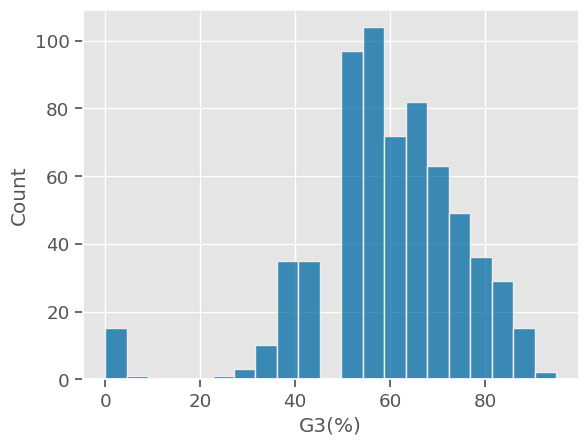

In [5]:
## visual distribution of % grades
ax = sns.histplot(df, x="G3(%)")

# Using pd.cut

defines the span of each bin or by defaults makes its own.

In [6]:
## defining bin edges, meaning the actual value span for each bin 
#in this case the first bin, G3 score from 0-60 is an "F"
bins = [0,60,70,80,90,100]
grades = pd.cut(df["G3(%)"], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

In [7]:
#If we say right=False, then the logic will change to match what we wanted, where scores up to 60 (but not 60)
grades = pd.cut(df["G3(%)"], bins=bins, right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

The downside to this approach is that 100 will no longer be included in the last bin, so we would to increase the final bin edge to 101.

In [8]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

## Adding Bin labels and saving as a column


In [9]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df["G3(%)"], bins, labels=bin_labels, include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [10]:
#add these values to our DataFrame as a new column 'FinalGrade'.
df["FinalGrade"] = pd.cut(df["G3(%)"], bins, labels=bin_labels, include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [11]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby("FinalGrade")["G3(%)"].agg(["min", "max", "count"])

,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


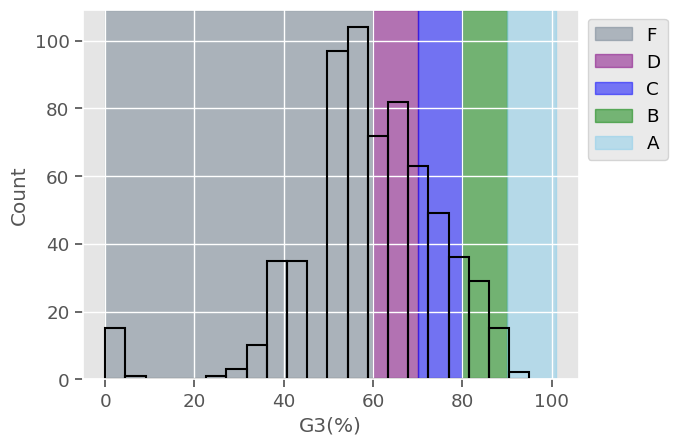

In [12]:
#color-coded regions for each letter grade
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1]);   

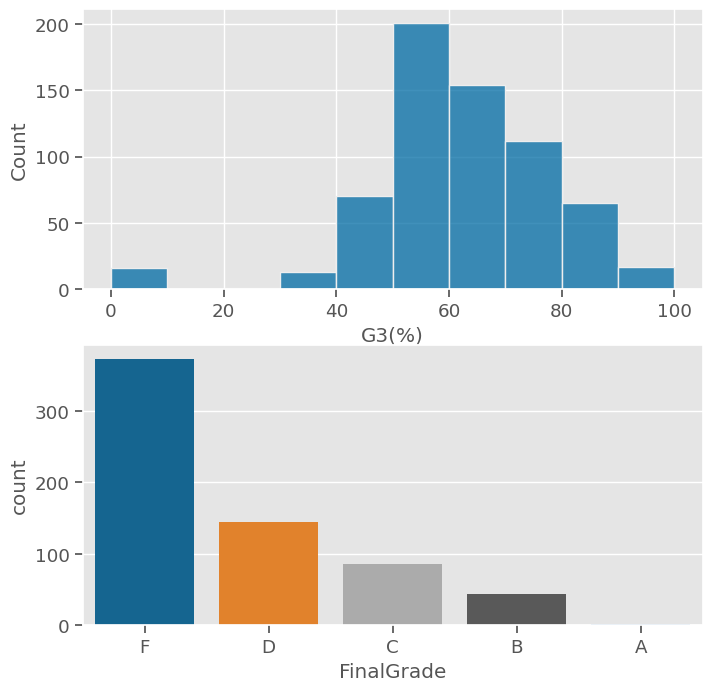

In [13]:
#We can also view these distributions on two separate graphs.
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);

# Making Our Final Target & X/y Data

In [14]:
## Define target as had a F or Above
df["target_F"] = df["FinalGrade"] == "F"
df["target_F"].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

# Train Test Split



In [15]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

# Preprocessing and Column Transformers



In [16]:
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


# RandomForestClassifier

## Function for Evaluating Classification Models


In [17]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



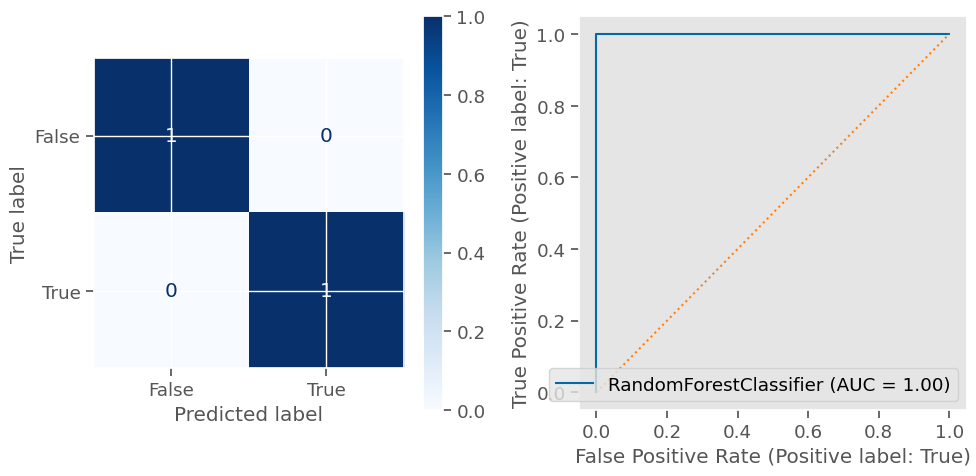

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



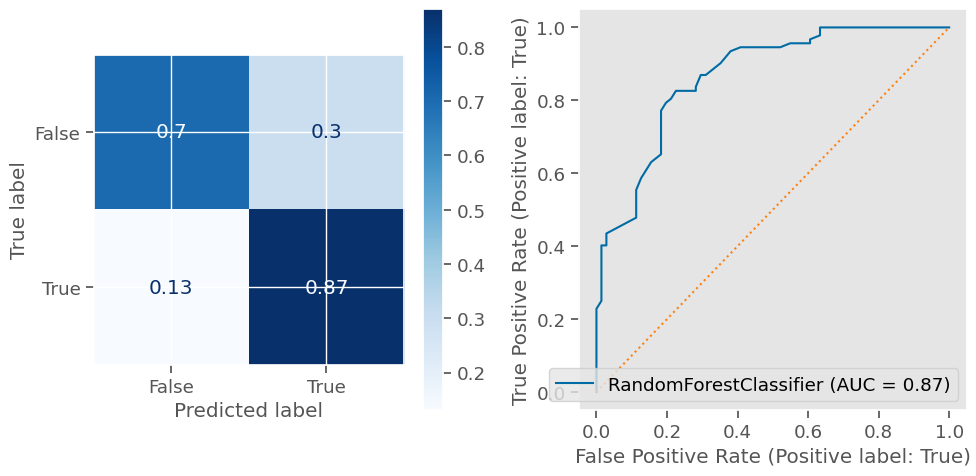

In [18]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

In [19]:
#Defining a Function for Feature Importance
def get_importances(model, feature_names=None, name="Feature Importance",
                    sort=False, ascending=True):
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names, name=name)
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [20]:
#Create a custom function to plot our importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    fig2, ax = plt.subplots()
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    plt.tight_layout();
    ## return ax in case want to continue to update/modify figure
    return ax

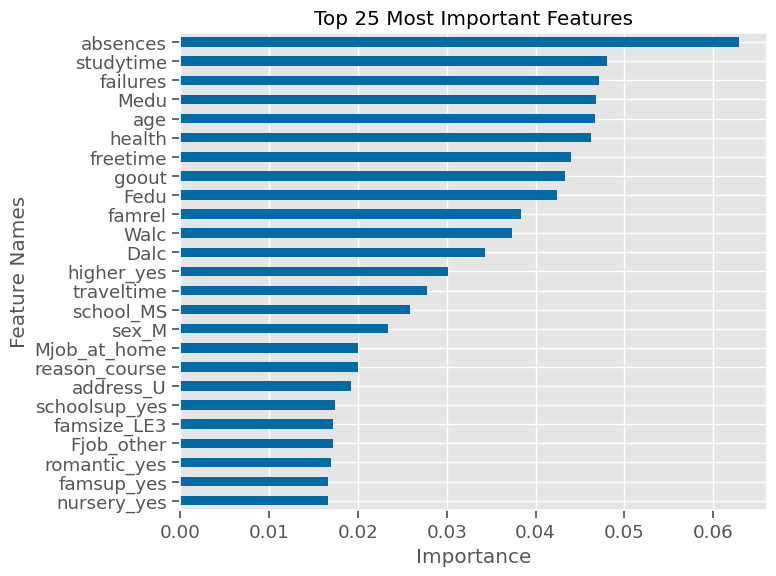

In [21]:
#plotting RandomForest model's top 25 important features
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances, top_n=25)

# Permutation Importances - RandomForest

In [22]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [23]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [24]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances, top_n=7)

In [25]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax


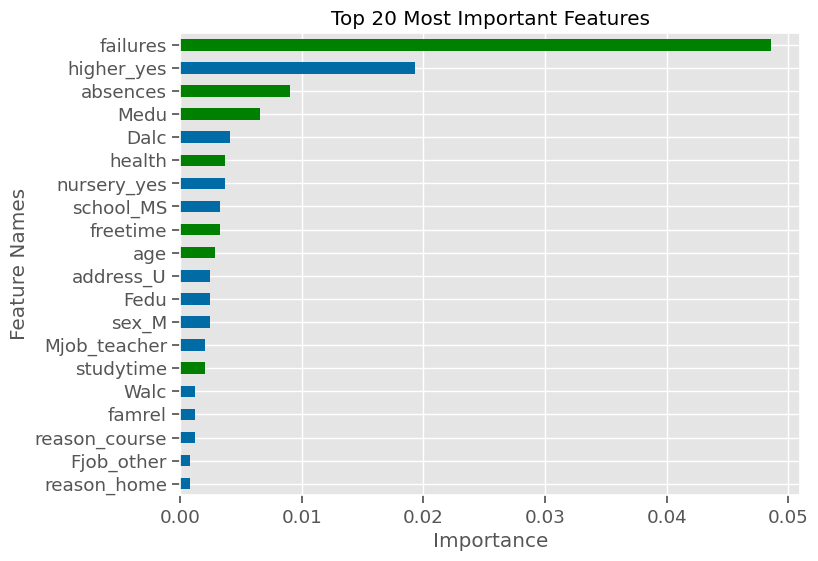

In [26]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color(rf_perm_importances, color_dict=colors_rf, top_n=20);



# Post-Modeling EDA


In [27]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


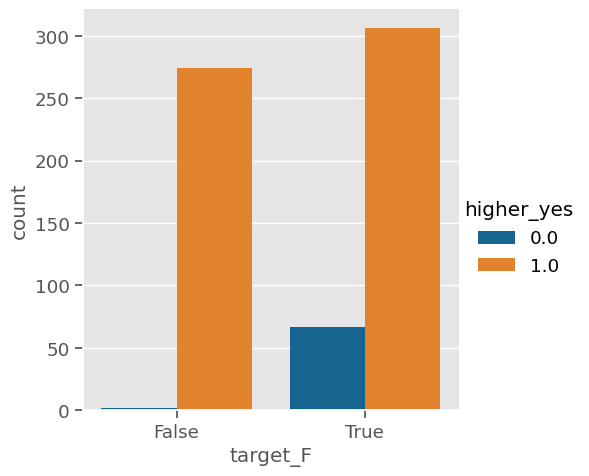

In [28]:
#the relationship between our target and the top 3 features.
sns.catplot(plot_df, kind="count", x="target_F", hue="higher_yes");

As we can see with our EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (blue group) in the Failing students (target_F==True) than the successful students.

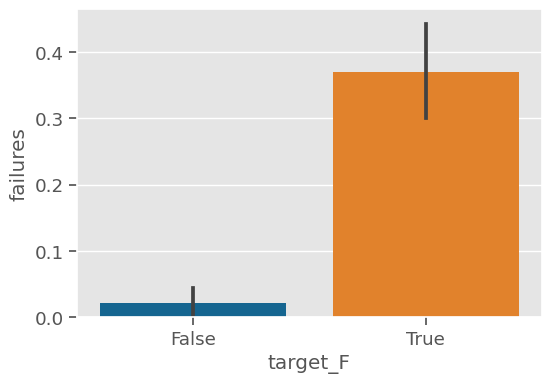

In [29]:
plt.figure(figsize=(6,4))
ax = sns.barplot(plot_df, x="target_F", y="failures")

We can see above that students who failed Portuguese had many more failures, on average

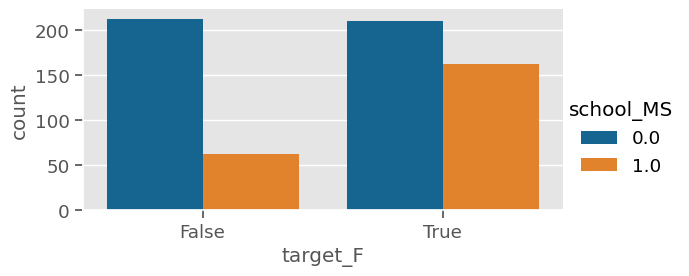

In [30]:
sns.catplot(plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);

doesnt seem that school_MS had much of a difference on the target_F group.

## Explaining Our Model

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



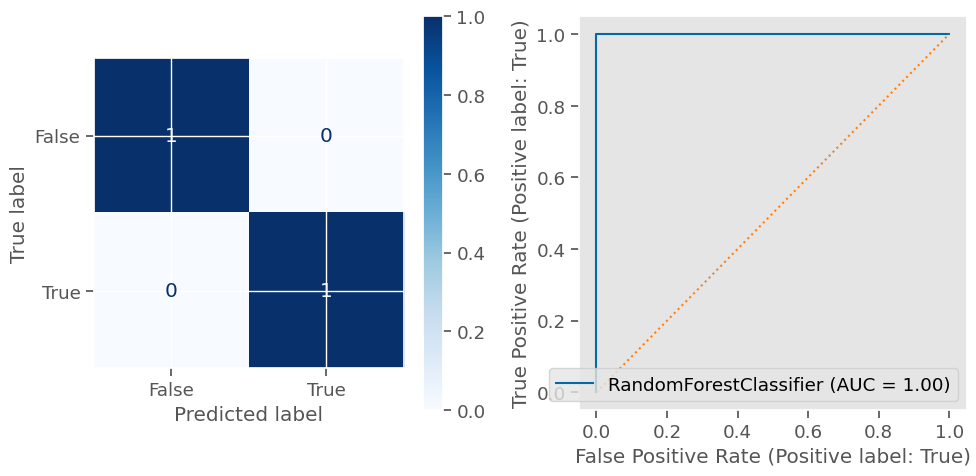

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



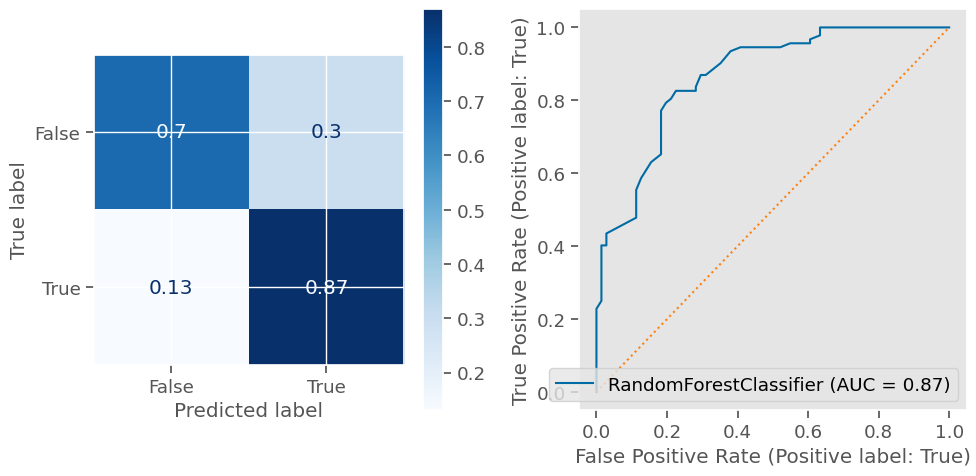

In [31]:
evaluate_classification(rf_clf, X_train_df, y_train, X_test_df, y_test)

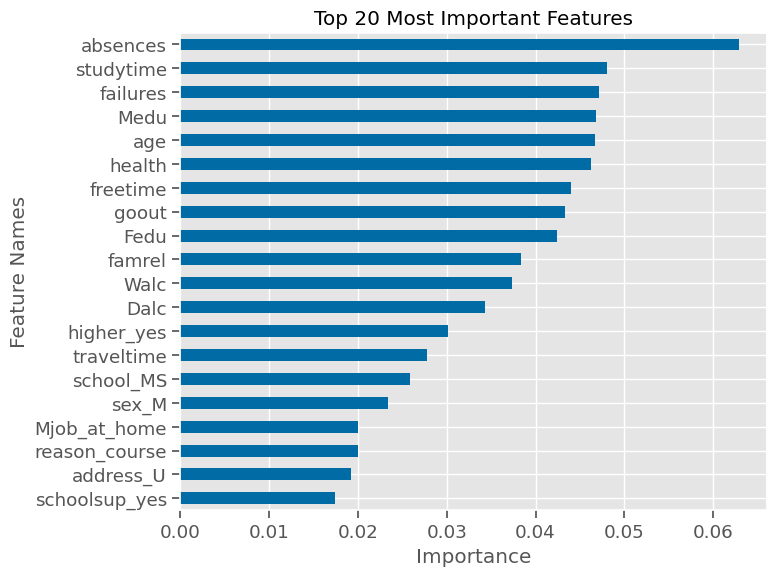

In [32]:
rf_importances = get_importances(rf_clf)
plot_importance(rf_importances, top_n=20);

## How To Use Shap


In [33]:
# Import shap and initialize javascript:
import shap
shap.initjs()

### SHAP Explainers

In order to calculate our SHAP values for our model & features, we will need to create an instance of a Model Explainer.

Explainer objects will need the model and some X and y data.

### Preparing Data for Shap


In [34]:
len(X_train_df)

486

Whenever the dataset is too large for your machine to process in a timely manner, we can use SHAP's utility for sampling a subset of our data (shap.sample).

Let's take just 400 observations from our X_train_df and save it as X_shap.

In [35]:
X_shap = shap.sample(X_train_df, nsamples=400, random_state=SEED)
X_shap.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [36]:
# X_shap to slice out the y-data that corresponds to our randomly selected X samples
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

473     True
340    False
452     True
555    False
70      True
       ...  
485     True
329    False
251     True
434     True
568     True
Name: target_F, Length: 400, dtype: bool

### Explaining Our RandomForest


### 1. Create a SHAP explainer using your fit model

In [37]:
explainer = shap.Explainer(rf_clf)
explainer

### Get SHAP values from explainer for your training data

In [38]:
## Getting the shap values
shap_values = explainer(X_shap, y_shap)
type(shap_values)

shap._explanation.Explanation

In [39]:
#the shape of the sample of X values we provided to our explainer
X_shap.shape

(400, 43)

In [40]:
shap_values.shape

(400, 43, 2)

### Exploring SHAP Explanation Values


In [41]:
#Each entry in the shap_values array is a new type of object called an Explanation
# Each explanation has these 3 components
shap_values[0]

.values =
array([[-1.13842083e-02,  1.13842083e-02],
       [-2.07155894e-02,  2.07155894e-02],
       [-3.84368042e-02,  3.84368042e-02],
       [-1.30807424e-02,  1.30807424e-02],
       [-6.02999552e-02,  6.02999552e-02],
       [ 1.82557215e-02, -1.82557215e-02],
       [-2.69649558e-02,  2.69649558e-02],
       [-5.03153954e-03,  5.03153954e-03],
       [-1.05418257e-02,  1.05418257e-02],
       [-2.79448284e-02,  2.79448284e-02],
       [-2.01135722e-02,  2.01135722e-02],
       [-5.84249592e-03,  5.84249592e-03],
       [-1.10150996e-02,  1.10150996e-02],
       [-4.34594738e-02,  4.34594738e-02],
       [-3.41156856e-02,  3.41156856e-02],
       [ 1.55429422e-03, -1.55429422e-03],
       [-4.90280939e-03,  4.90280939e-03],
       [-3.01033054e-03,  3.01033054e-03],
       [-4.70831504e-02,  4.70831504e-02],
       [-1.32577194e-03,  1.32577194e-03],
       [-5.50487702e-03,  5.50487702e-03],
       [-1.84900911e-04,  1.84900911e-04],
       [-2.73608067e-03,  2.73608067e-03],
 

### Limiting our SHAP Values to one class


In [42]:
# slicing for failing values 
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 43)

In [43]:
pd.DataFrame(shap_vals_1.values, columns=X_shap.columns)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.011384,0.020716,0.038437,0.013081,0.060300,-0.018256,0.026965,0.005032,0.010542,0.027945,0.020114,0.005842,0.011015,0.043459,0.034116,-0.001554,0.004903,0.003010,0.047083,0.001326,0.005505,0.000185,0.002736,-0.000206,0.000053,-0.000513,0.000682,0.005284,0.015105,0.003846,-0.000981,0.008370,0.000669,0.002170,0.000386,-0.001762,0.007524,-0.000279,0.003051,-0.001165,-0.010152,-0.000843,-0.001545
1,-0.027710,-0.008140,-0.031137,-0.010662,0.048538,-0.033017,-0.014846,-0.004333,0.002821,-0.030451,0.004671,0.019312,-0.049359,-0.040658,0.025094,-0.011837,-0.003676,0.002539,-0.017287,-0.034561,-0.001492,-0.003244,-0.008045,-0.001217,-0.001410,-0.010309,-0.006509,0.003259,-0.014335,-0.028037,-0.004501,0.004801,-0.003813,-0.006967,0.000052,-0.007353,0.004714,-0.004393,-0.005905,-0.009707,-0.023266,-0.001175,-0.002872
2,0.017498,0.033720,0.019910,-0.015477,0.007660,-0.026705,-0.007421,0.024356,0.041072,-0.015493,0.001707,0.004705,0.023944,0.080968,-0.012418,0.038836,0.007253,0.001445,-0.007734,0.002473,-0.004592,0.000345,0.003054,-0.000579,-0.000297,0.020917,0.013851,0.004549,0.028476,0.003477,-0.001414,0.007246,0.004909,0.006272,-0.000168,-0.001285,0.007389,-0.000825,0.007617,0.004807,-0.014749,0.000517,-0.006236
3,0.001584,-0.001950,-0.002211,0.009018,-0.100554,-0.034038,-0.010366,-0.004359,-0.006634,-0.023250,-0.011017,-0.009211,0.006421,0.009165,-0.017142,-0.006497,-0.001384,0.001740,-0.011233,0.001939,-0.005730,-0.001168,-0.000104,-0.000309,-0.001226,0.005247,0.002653,0.001930,-0.022959,-0.032570,-0.004139,-0.005658,-0.008045,-0.009319,-0.001257,0.010356,-0.002402,-0.001117,0.000297,-0.010842,-0.018698,-0.017263,0.005885
4,0.022957,0.036215,0.042516,0.002916,-0.003772,-0.025612,-0.000121,0.027580,-0.012289,-0.005846,-0.002680,0.037058,0.013698,-0.001031,0.052819,-0.002785,-0.000481,0.004541,-0.001856,0.003198,0.005446,0.001269,0.002760,0.000272,-0.000521,0.014929,0.004001,0.003839,-0.004745,0.007078,-0.000542,-0.009265,0.012346,0.018728,-0.000538,-0.005290,0.006161,-0.001668,0.017906,-0.002578,-0.014373,0.000579,0.000763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.005511,0.033119,0.010145,0.017424,0.015627,-0.029179,-0.008141,0.002359,0.033244,-0.012120,-0.002334,0.005569,-0.034156,0.076776,-0.018405,0.046579,0.005081,0.003934,0.049889,0.004251,0.009304,0.005396,0.003294,-0.000080,0.000056,0.006816,0.001113,0.003842,0.027189,0.004880,-0.000278,0.004840,0.004524,0.001877,-0.000272,-0.002807,0.011844,-0.000750,-0.000773,0.000830,-0.015736,-0.000518,-0.005164
396,-0.032181,0.009915,-0.005112,-0.004760,-0.026775,-0.036944,-0.019854,0.002937,-0.010496,-0.025360,-0.019016,0.014140,0.037503,-0.035801,-0.026033,-0.019392,-0.001293,0.002912,-0.013300,0.002981,-0.018427,-0.005467,0.000219,-0.000940,-0.000624,0.001273,-0.000501,0.001895,0.004304,-0.002170,-0.001563,0.007676,-0.001384,-0.002053,-0.001202,-0.006373,-0.004741,-0.001626,-0.002996,-0.009518,-0.020028,-0.008021,-0.018226
397,0.021756,0.043065,0.046708,0.008154,0.065451,-0.020210,-0.007674,0.060154,-0.017536,-0.008487,0.005505,0.051341,0.011208,-0.023840,0.002286,0.000508,0.002275,0.000151,-0.007267,0.003346,0.000736,0.002941,0.002434,0.000299,-0.000542,0.003659,0.005633,0.002177,0.005311,-0.010871,-0.001928,0.011902,0.000797,0.002925,0.000673,-0.003313,-0.004439,-0.000149,0.010761,-0.001405,-0.016712,0.001859,0.013940
398,0.011774,0.014196,0.014552,-0.002349,-0.048389,-0.021571,0.065

## SHAP Summary Plots for Global Explanations

### Summary Plot - Bar


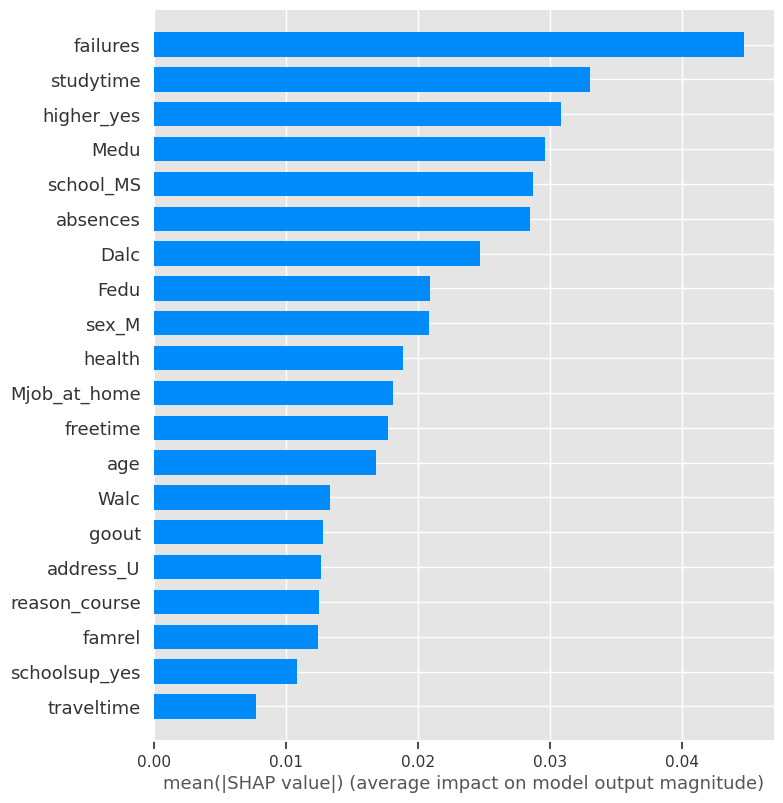

In [44]:
# The bar plot summary shows the average of the SHAP value for each feature across all samples.
shap.summary_plot(shap_vals_1, features= X_shap, plot_type="bar")

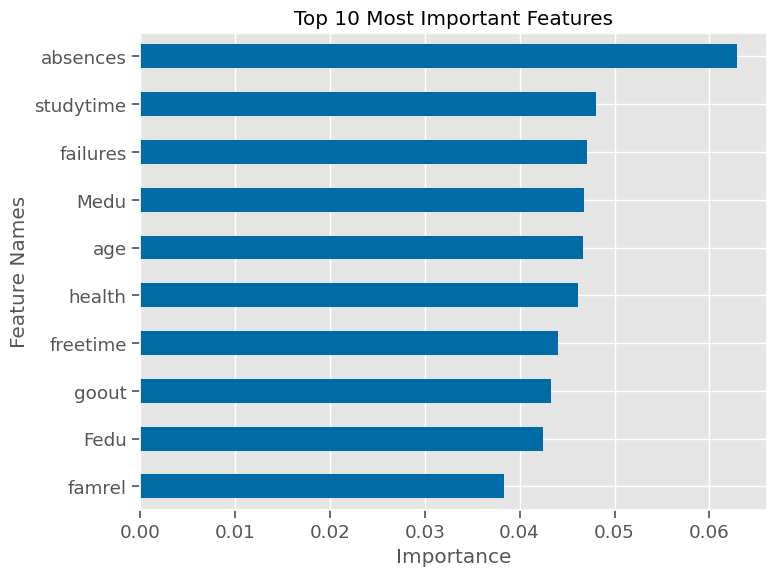

In [45]:
# comparing to random forest calculated as the feature importances, and compare the results.
plot_importance(rf_importances,top_n=10);


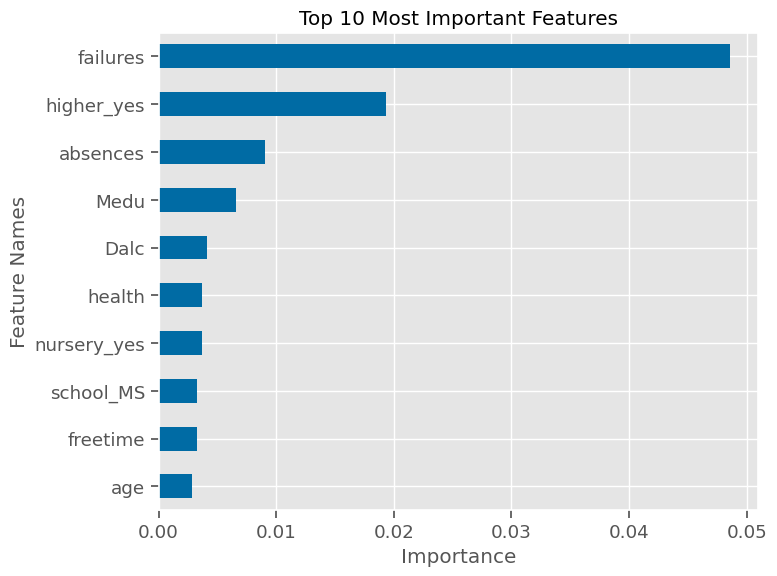

In [46]:
# permutation importances we calculated for the model.
plot_importance(rf_perm_importances,top_n=10);

# Summary Plot - dot (default)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


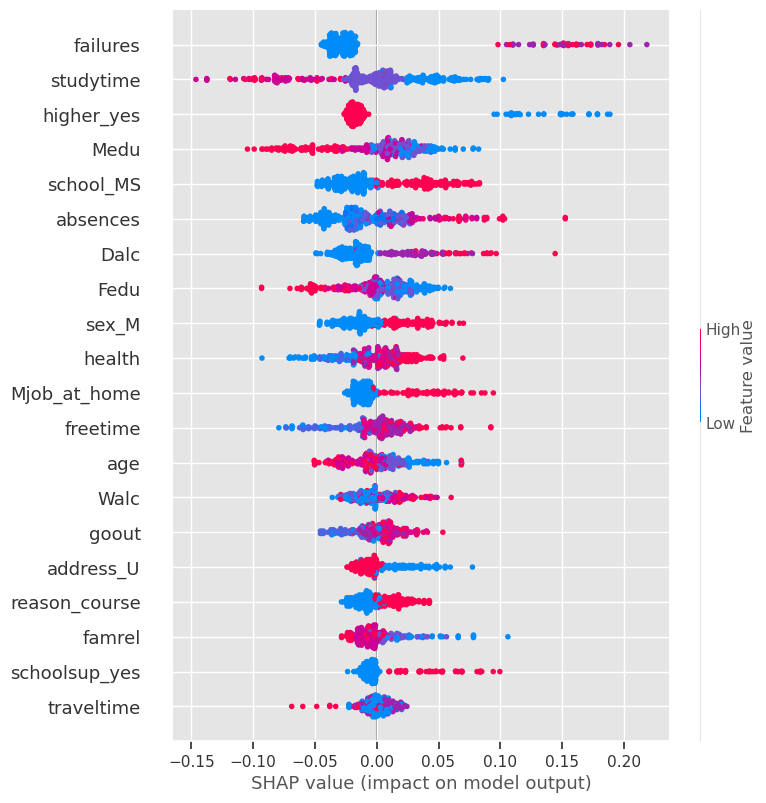

In [47]:
# the "dot" version of the summary plot
shap.summary_plot(shap_vals_1,X_shap);

Reading SHAP Summary Plots

In the summary plot above:

* Each dot represents an observation/row (in this case, a student).
* The features are plotted on the y-axis and are sorted from the most impactful features to the least (from top to bottom).
* The calculated Shapley values for each observation are plotted on the x-axis. The more positive the value, the more the feature pushed the model's prediction towards predicting the current class (failing).
* For each feature, the original values of that feature are represented with color.
* Using the default colormap, blue represents the lowest value in the column and red represents the highest.
* For one hot encoded categories, <mark>blue=0 (not failing), red = 1 (failing).</mark>
* For numeric features: the shade of the color indicates where it falls in the feature's distribution.


Let's just follow the red dots for each feature. Red means the feature value is higher:

* If the red is on the right (positive), higher values of this feature increase the chance the prediction will be fail.
* If the red is on the left (negative), higher values of this feature decrease the chances the prediction will be fail.

Remember, our SHAP explanations and visualizations are explaining how our model was using the features and how they influenced the model's prediction.

## Saving Summary Plots


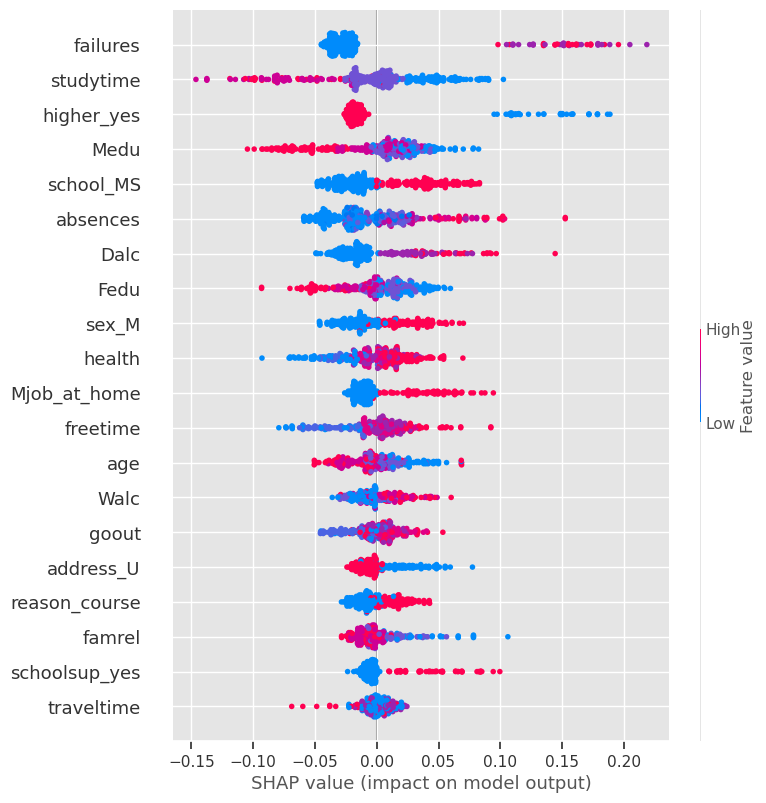

In [48]:
fig = shap.summary_plot(shap_vals_1,X_shap,)


In [49]:
print(type(fig))
fig

<class 'NoneType'>


We can use fig=plt.figure(), fig, ax = plt.subplots(), fig = plt.gcf()
We will use the plt.subplots approach in this lesson, since it will create both the fig and axis.

## Using fig.savefig

In [50]:
#making images folder
import os
os.makedirs("images/", exist_ok=True)

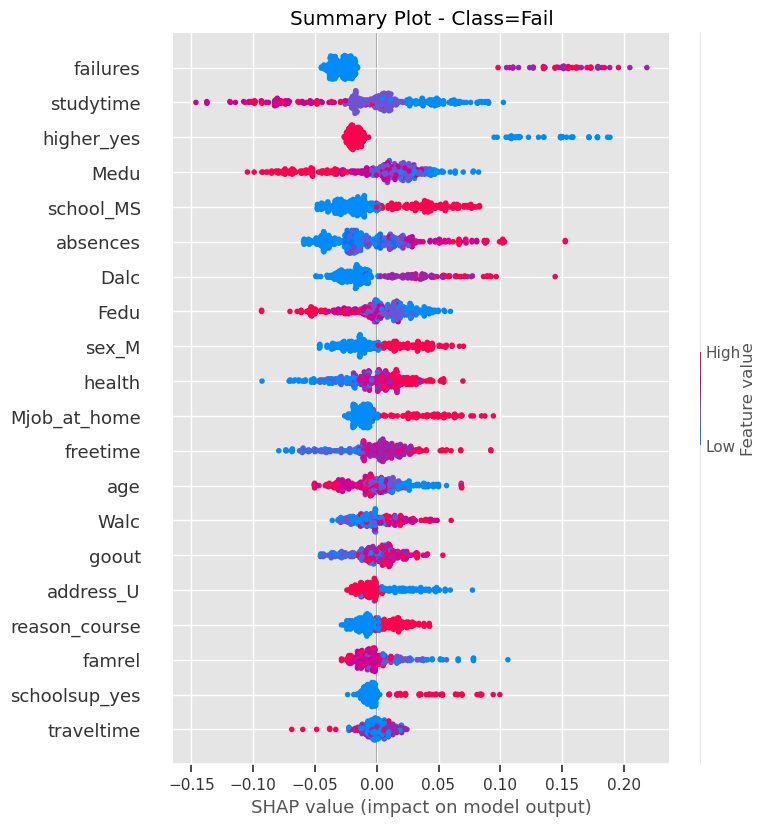

In [51]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_1, X_shap, show=False)
ax.set_title('Summary Plot - Class=Fail');
fig.savefig('images/summary_plot_1.png')

## Displaying Plot In This Cell 
`<img src="images/summary_plot_1.png" width=60%>`

<img src="images/summary_plot_1.png" width=60%>

Can also use pixels

`<img src="images/summary_plot_1.png" width=400px>`

<img src="images/summary_plot_1.png" width=400px>

# Intro to Force Plots - Single Observation


## Interpreting an individual Force Plot (Example 1)


In [52]:
# select a row (single student) to use for our force_plot
# arbitrarily choosing a row to use
i = 100
single_row_X = X_shap.iloc[i]
single_row_y = y_shap.iloc[i]
single_shap_vals = shap_vals_1[i]
single_row_X.head(10)

age           17.0
Medu           4.0
Fedu           3.0
traveltime     2.0
studytime      2.0
failures       0.0
famrel         4.0
freetime       4.0
goout          4.0
Dalc           4.0
Name: 189, dtype: float64

In [53]:
## true class of selected row
single_row_y

True

To create a force plot, the function requires:
the expected_value (base value) for the class of interest - which we can find in our explainer.

The SHAP values for just that row and the features for just that row.

The features (X data) for just the 1 row.


In [54]:
## Individual forceplot (with the complex shap vals)
shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
               features=single_row_X)

For example, if you're trying to predict the price of a car and have features like age, mileage, and brand, the final SHAP value would tell you how much the specific age, mileage, and brand of that car collectively contribute to the predicted price, considering how they interact with each other and the base reference.

Visually, the color with the wider bar "wins", and this decides the prediction. In this case, the contributions of the red features are greater than the blue which means a greater "push" towards failing, so the final prediction is class 1: failing.

The wider the segment is for the feature, the greater its contribution to the prediction is.

In [55]:
#Let's select another observation at random:
# arbitrarily choosing a row to use
i = 200
single_row_X = X_shap.iloc[i]
single_row_y = y_shap.iloc[i]
single_shap_vals = shap_vals_1[i]
single_row_X.head(10)

age           18.0
Medu           2.0
Fedu           2.0
traveltime     2.0
studytime      4.0
failures       0.0
famrel         4.0
freetime       4.0
goout          4.0
Dalc           1.0
Name: 390, dtype: float64

In [56]:
#Let's see whether this student passed or failed.
## true class of selected row
single_row_y

False

## Interpreting an individual Force Plot (Example 2)

In [57]:
shap.force_plot(explainer.expected_value[1],shap_values=single_shap_vals.values,
               features=single_row_X)

The red features push the prediction to a greater value (towards class 1: failing), while the blue features push the prediction to a lower value (towards class 0: passing).

As you can see, studytime is the most important feature for this student. Further, the actual value for each feature is listed. For this student, studytime = 4 (which corresponds to >10 hours per week).

## Global shap.force_plot

use the entire set of SHAP values and our X_shap variable, instead of a single observation.

In [58]:
## Global Forceplot
shap.force_plot(explainer.expected_value[1],shap_vals_1.values,features=X_shap)

The global force plot is essentially individual force plots (but for each row) rotated 90 degrees.
Additionally, the force plot rearranged the rows in the data to sort them by similar values.

# Comparing SHAP Usage - by Model


## Fit Each Model


### RandomForestClassifier


In [59]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df, y_train)

RandomForestClassifier()

### Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_df, y_train)

LogisticRegression(max_iter=1000)

### KNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_df, y_train)

KNeighborsClassifier(n_neighbors=3)

## Reduce Sample Size


In [62]:
# limit our sample size to 200 observations
X_shap = shap.sample(X_train_df, nsamples=200, random_state=SEED)
X_shap.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


### Match X and y for sample

Since we made our X_train_df using the index from the original X, we can use the index of X_shap to slice out the y-data that corresponds to our samples.

In [63]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap.head()

473     True
340    False
452     True
555    False
70      True
Name: target_F, dtype: bool

### Comparing Explainers

#### Random Forest


In [64]:
# instantiate an explainer for our Random Forest model
explainer = shap.Explainer(rf_clf)
explainer

In [65]:
# examine the shape of the output:
shap_values = explainer(X_shap, y_shap)
print(type(shap_values))
shap_values.shape

<class 'shap._explanation.Explanation'>


(200, 43, 2)

We get 3 dimensional SHAP values, where the 3rd dimension is the number of classes in our target

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


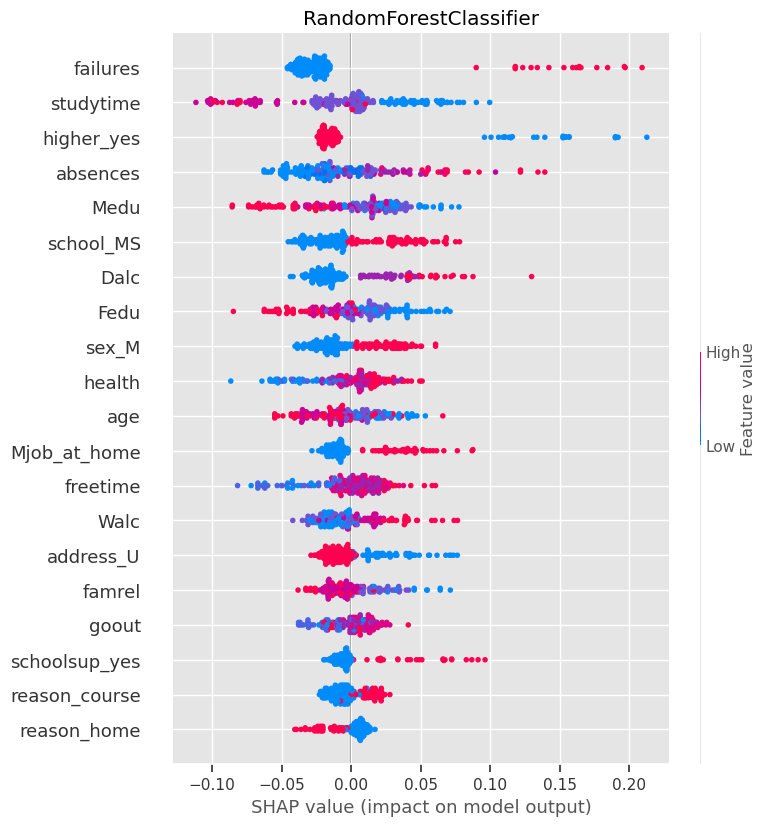

In [66]:
# slice out the desired class (in this case, failing = class 1) using shap_values[:,:,1]
## option B: saving class as separate var first
shap_vals_1 = shap_values[:,:,1]
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_1,features= X_shap,show=False)
ax.set_title('RandomForestClassifier');

####  LogisticRegression

In [67]:
## logreg
#Necessary to add the dataset you are using (X_shap)
explainer_logreg = shap.Explainer(logreg, X_shap)
explainer_logreg

In [68]:
## Getting the shap values
shap_values_logreg = explainer_logreg(X_shap)
print(type(shap_values_logreg))
shap_values_logreg.shape

<class 'shap._explanation.Explanation'>


(200, 43)

We only get a 2-dimensional output (Remember with Random Forest, the output was 3d).

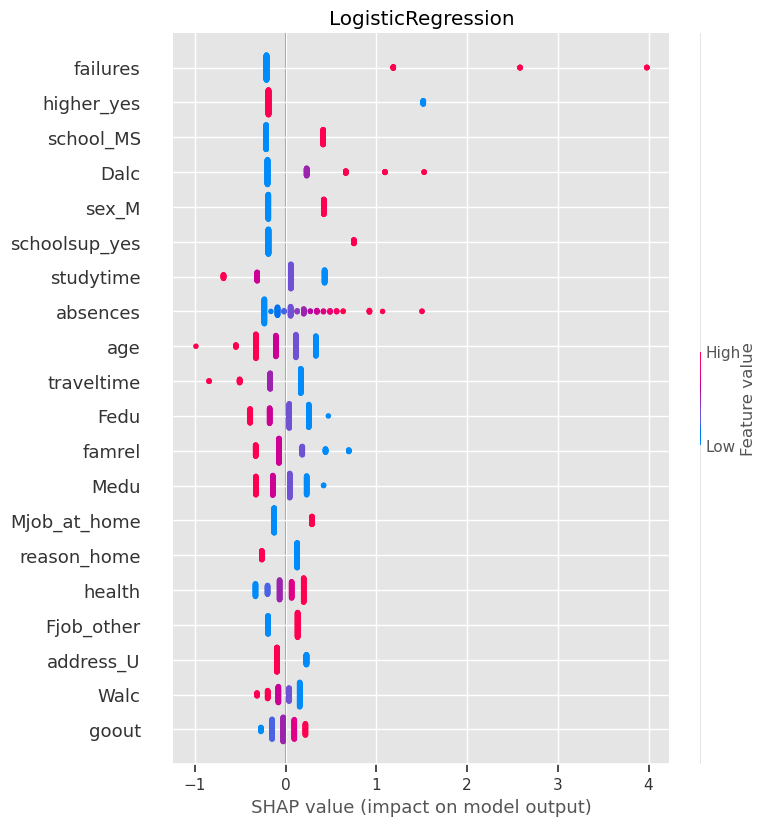

In [69]:
#The code below will produce a summary plot for our logistic regression model:

fig, ax = plt.subplots()
shap.summary_plot(shap_values_logreg, features=X_shap, show=False)
ax.set_title("LogisticRegression");

#### KNN

In [70]:
#pass our KNN's .predict method as the first argument
explainer_knn = shap.Explainer(knn.predict, X_shap)
explainer_knn

In [71]:
# examine the shape of the output
shap_vals_knn = explainer_knn(X_shap)
print(type(shap_vals_knn))
shap_vals_knn.shape

Permutation explainer: 201it [00:39,  3.90it/s]                                 

<class 'shap._explanation.Explanation'>


(200, 43)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Text(0.5, 1.0, 'KNN')

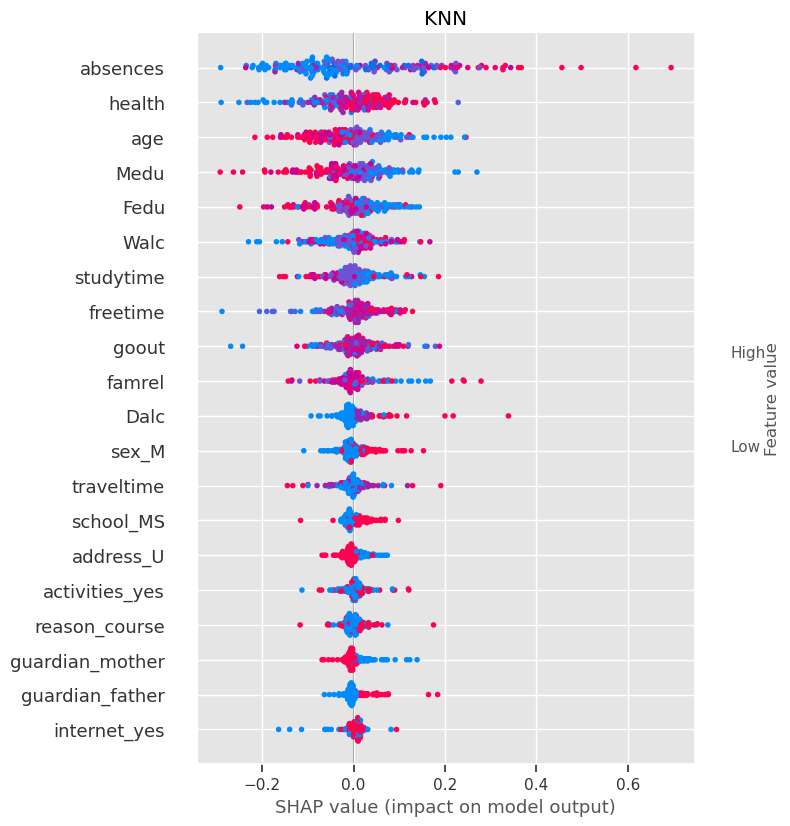

In [72]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_knn,features= X_shap, show=False)
ax.set_title('KNN')